In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import torch 
import torch.nn.functional as F 
from torch.utils import data 
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler 

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

from sko.GA import GA
from sko.DE import DE
from sko.PSO import PSO
from time import time

from ortools.sat.python import cp_model
from ortools.linear_solver import pywraplp

from plot_fn import plot_contour, plot_obj_surface
from metrics_fn import Rsquare, mse

In [15]:
variation_ratio =  0.01
n = 3000
seed = np.random.RandomState(1122)
def f(x1, x2):
    return (-np.cos(np.pi*(x1))*np.cos(2*np.pi*(x2))) / (1 +np.power(x1,2) +np.power(x2,2))

xy_min = [-2, -2]
xy_max = [2, 2]

X = seed.uniform(low=xy_min, high=xy_max, size=(n,2))
y = np.array([f(x[0], x[1])+seed.randn()*variation_ratio for x in X])

In [16]:
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, random_state=1122)


df_train_X = pd.DataFrame(train_X)
df_val_X = pd.DataFrame(val_X)
df_train_y = pd.DataFrame(train_y)
df_val_y = pd.DataFrame(val_y)

In [22]:
class Model(torch.nn.Module):
    def __init__(self, D_in=2, H=256, D_out=1, Hn=4):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=256),
            torch.nn.LeakyReLU(negative_slope=0.01),
            torch.nn.Linear(in_features=256, out_features=256),
            torch.nn.LeakyReLU(negative_slope=0.01),
            torch.nn.Linear(in_features=256, out_features=256),
            torch.nn.LeakyReLU(negative_slope=0.01),
            torch.nn.Linear(in_features=256, out_features=256),
            torch.nn.LeakyReLU(negative_slope=0.01),
            torch.nn.Linear(in_features=256, out_features=1),
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
        
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
def to_tensor(x: Union[np.array, pd.DataFrame], device: str='cpu'):
    return torch.tensor(x.values).float().to(device) if type(x) == pd.DataFrame else torch.tensor(x).float().to(device)


y_val = array2tensor(df_val_y.values)
X_val = torch.tensor(df_val_X.values).float().to(device)

# Prepare data for batch training
y_train = torch.tensor(df_train_y.values).float().to(device) # Unsqueeze to match the shape of the output of our model
X_train = torch.tensor(df_train_X.values).float().to(device)
dataset = TensorDataset(X_train, y_train) # Make X,y into dataset so we can work with DataLoader which iterate our data in batch size
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define Model,Optimizer, Criterion
nn = Model().to(device) # Define model and send to gpu
optimizer = torch.optim.SGD(nn.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001) # What approach we use to minimize the gradient
criterion = torch.nn.MSELoss() # Our loss function

In [24]:
nn

Model(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [25]:
train_losses = [] # Store the training loss
val_losses = [] # Store the validation loss
epochs = 500 # Number of time we go over the whole dataset

for epoch in range(epochs):
    running_loss = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        # Forward propagation
        y_pred = nn(X) # Make prediction by passing X to our model
        loss = criterion(y_pred, y) # Calculate loss 
        running_loss += loss.item() # Add loss to running loss
        
        # Backward propagation
        optimizer.zero_grad() # Empty the gradient (look up this function)
        loss.backward() # Do backward propagation and calculate the gradient of loss with respect to every parameters (that require gradient)
        optimizer.step() # Adjust parameters to minimize loss
    
    # Append train loss
    train_losses.append(running_loss/(batch + 1)) # Add the average loss of this iteration to training loss
    
    # Check test loss
    y_pred = nn(X_val)
    val_loss = criterion(y_pred, y_val).item()
    val_losses.append(val_loss)

In [26]:
# Plotting loss
def plot_loss(losses, axes=None, epoch_start = 0):
    x = [i for i in range(1 + epoch_start, len(losses) + 1)]
    sns.lineplot(ax=axes, x=x, y=losses[epoch_start:])
    
    
def plot_epoch_loss(train_losses, test_losses, epoch1=0, epoch2=10, epoch3=50, epoch4=150):
    fig, axes = plt.subplots(2, 2, figsize=(12,6), constrained_layout = True)
    fig.suptitle("Losses against Epochs")

    axes[0][0].set_title('Epoch Start at ' + str(epoch1))
    plot_loss(train_losses, axes[0][0], epoch1)
    plot_loss(test_losses, axes[0][0], epoch1)

    axes[0][1].set_title('Epoch Start at ' + str(epoch2))
    plot_loss(train_losses, axes[0][1], epoch2)
    plot_loss(test_losses, axes[0][1], epoch2)

    axes[1][0].set_title('Epoch Start at ' + str(epoch3))
    plot_loss(train_losses, axes[1][0], epoch3)
    plot_loss(test_losses, axes[1][0], epoch3)

    axes[1][1].set_title('Epoch Start at ' + str(epoch4))
    plot_loss(train_losses, axes[1][1], epoch4)
    plot_loss(test_losses, axes[1][1], epoch4)

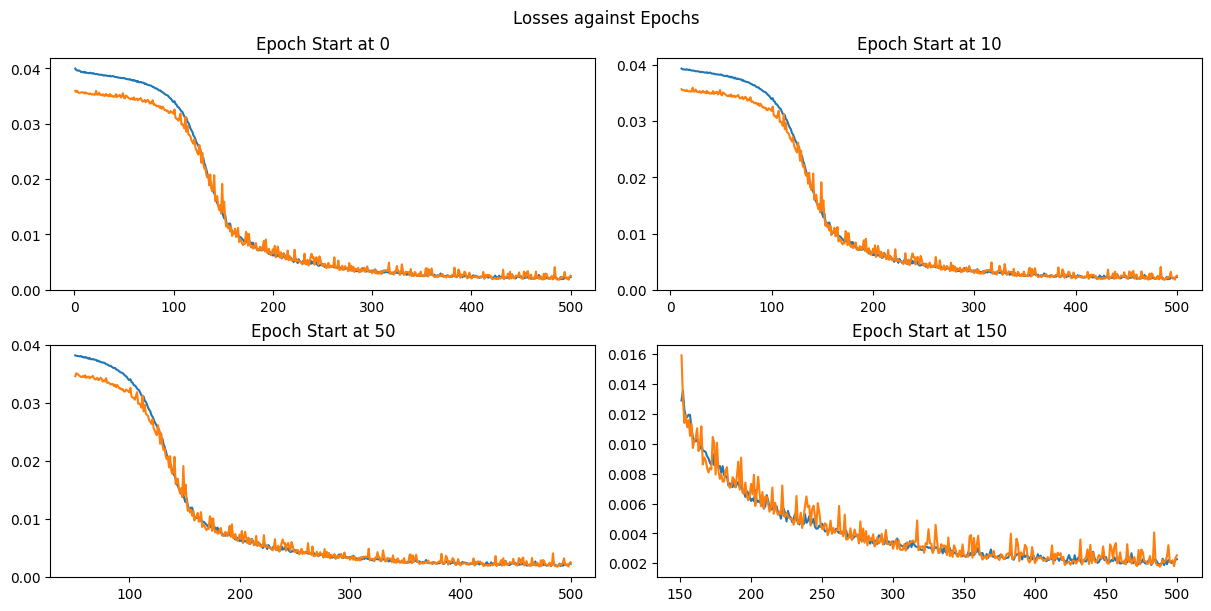

In [27]:
plot_epoch_loss(train_losses, val_losses)

In [28]:
lm = LinearRegression()
lgb = LGBMRegressor()
xgb = XGBRegressor()

lm.fit(train_X, train_y)
lgb.fit(train_X, train_y)
xgb.fit(train_X, train_y)

y_hat_LM = lm.predict(val_X)
y_hat_LGB = lgb.predict(val_X)
y_hat_XGB = xgb.predict(val_X)
nn.eval()
y_hat_NN = nn(X_val).detach_()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 2
[LightGBM] [Info] Start training from score 0.004254


-- MSE
0.03600586342422091
0.002499773682267528
0.0024943026228618393
0.0025357042904943228
------------------------------
-- R square
0.00010588620955009898
0.9305805012572986
0.9307324342919684
0.929582701951373
------------------------------


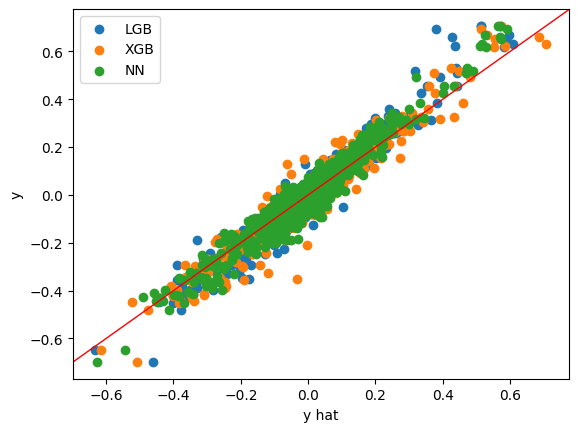

In [29]:
print('-- MSE')
print(mse(val_y, y_hat_LM))
print(mse(val_y, y_hat_LGB))
print(mse(val_y, y_hat_XGB))
print(torch.mean((y_val - y_hat_NN)**2).item())
print('-'*30)

print('-- R square')
print(Rsquare(val_y, y_hat_LM))
print(Rsquare(val_y, y_hat_LGB))
print(Rsquare(val_y, y_hat_XGB))
print(1-torch.sum((y_val - y_hat_NN)**2).item()/torch.sum((y_val - y_val.mean())**2).item())
print('-'*30)

# plt.scatter(y_hat_LM, val_y, label='LM')
plt.scatter(y_hat_LGB, val_y, label='LGB')
plt.scatter(y_hat_XGB, val_y, label='XGB')
plt.scatter(y_hat_NN.cpu().numpy(), val_y, label='NN')
plt.axline(xy1=(0, 0), slope=1, color='r', lw=1)

plt.xlabel('y hat')
plt.ylabel('y')
plt.legend()

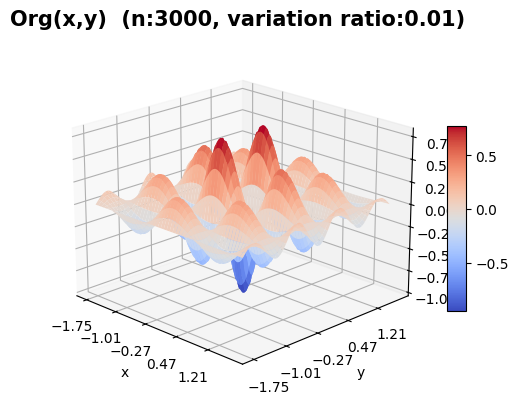

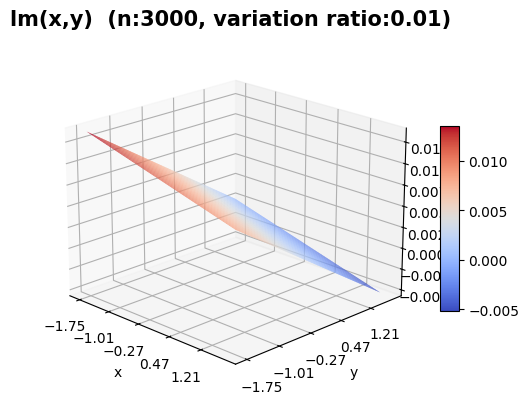

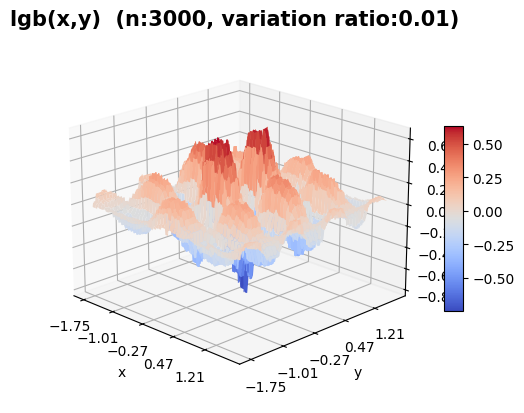

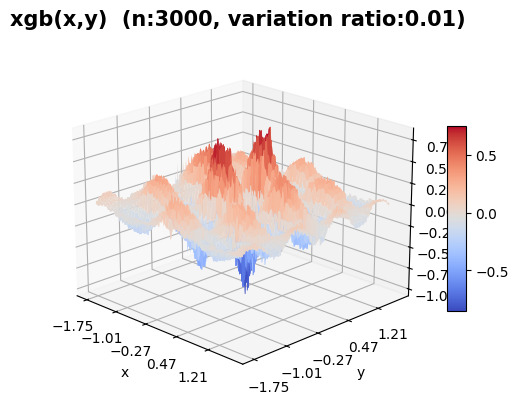

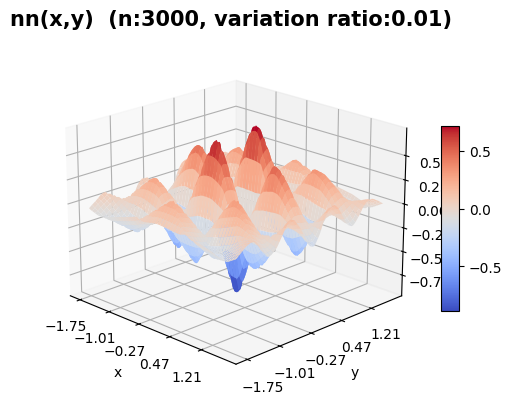

In [30]:
plot_obj_surface(variation_ratio, n, f)
plot_obj_surface(variation_ratio, n, f, lm, 'lm')
plot_obj_surface(variation_ratio, n, f, lgb, 'lgb')
plot_obj_surface(variation_ratio, n, f, xgb, 'xgb')
plot_obj_surface(variation_ratio, n, f, nn, 'nn')

d:\Delta\OptML\Sim_1\plot_fn.py:65: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour = plt.contour(X, Y, Z, linewidth = 5, cmap=plt.cm.coolwarm)


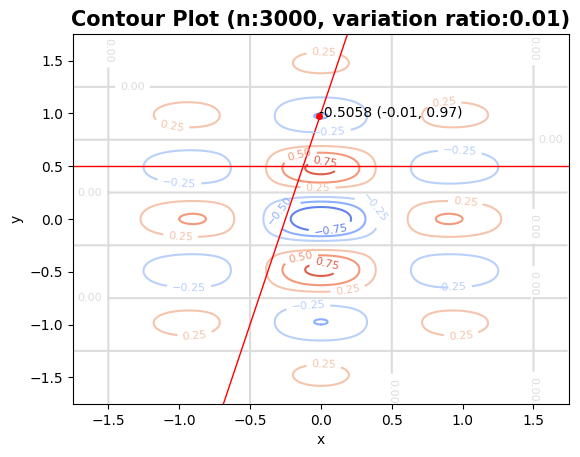

d:\Delta\OptML\Sim_1\plot_fn.py:65: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour = plt.contour(X, Y, Z, linewidth = 5, cmap=plt.cm.coolwarm)


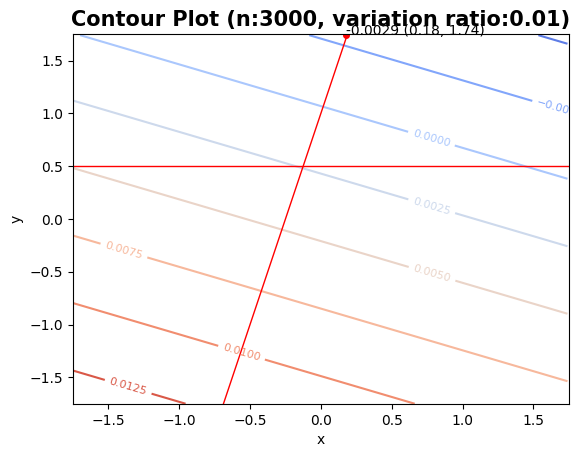

d:\Delta\OptML\Sim_1\plot_fn.py:65: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour = plt.contour(X, Y, Z, linewidth = 5, cmap=plt.cm.coolwarm)


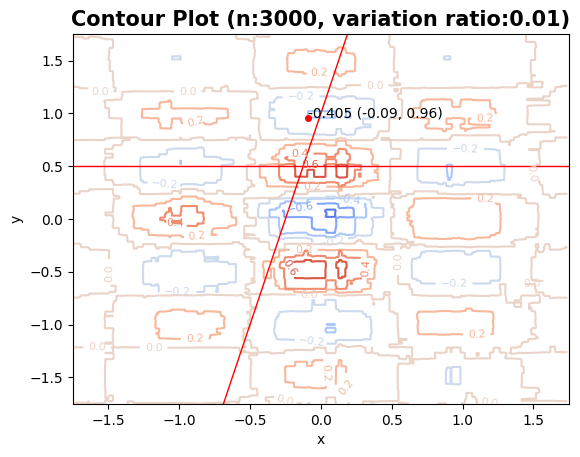

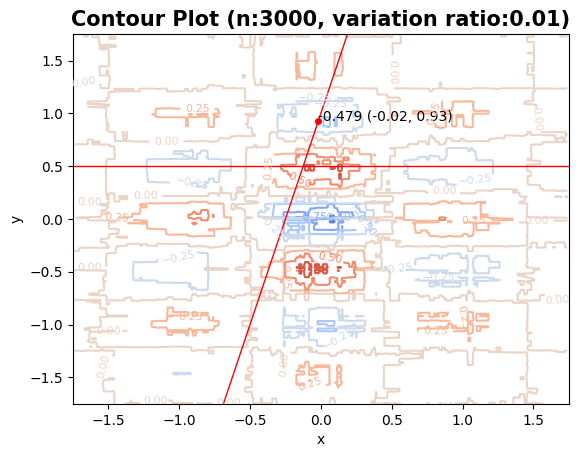

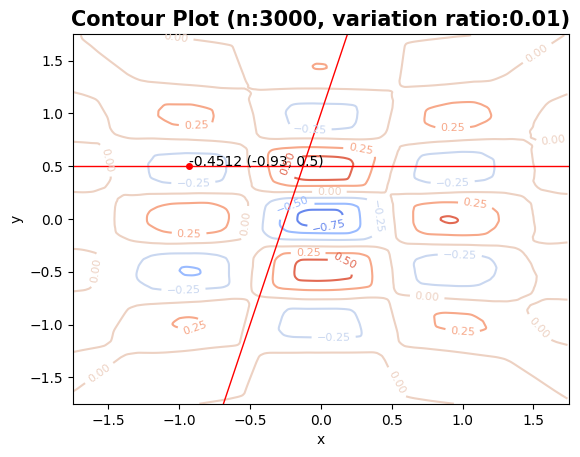

In [31]:
plot_contour(variation_ratio, n, f)
plot_contour(variation_ratio, n, f, lm, 'lm')
plot_contour(variation_ratio, n, f, lgb, 'lgb')
plot_contour(variation_ratio, n, f, xgb, 'xgb')
plot_contour(variation_ratio, n, f, nn, 'nn')

In [32]:
def obj_func_lm(p):
    x1, x2 = p
    return float(lm.predict(np.array([[x1, x2]])).item())

def obj_func_lgb(p):
    x1, x2 = p
    return float(lgb.predict(np.array([[x1, x2]])).item())

def obj_func_xgb(p):
    x1, x2 = p
    return float(xgb.predict(np.array([[x1, x2]])).item())

def obj_func_nn(p):
    x1, x2 = p
    nn.eval()
    return float(nn(torch.Tensor([x1, x2]).float().to(device)).item())

In [33]:
def optimize_f_hat(obj_func):

    '''
    min f(x1, x2) = f(x1, x2)
    s.t.
        x2 >= 0.5  => 0.5-x2 <= 0
        x2 - 4*x1 >= 1  => 1-x2+4*x1 <= 0
        -1.75 <= x1, x2 <= 1.75
    '''
    constraint_ueq = [
        lambda x: 0.5-x[1],
        lambda x: 1-x[1]+4*x[0]
    ]

    max_iter = 1000
    size_pop = 100
    # DE
    start = time()
    de = DE(
        func=obj_func, 
        n_dim=2, 
        size_pop=size_pop, 
        max_iter=max_iter, 
        lb=[-1.75, -1.75], 
        ub=[1.75, 1.75],
        # constraint_eq=constraint_eq, 
        constraint_ueq=constraint_ueq,

        )

    best_x, best_obj_func = de.run()
    print('best_x:', best_x, '\nbest_obj_func:', best_obj_func)
    print('total time cost : {time_diff}'.format(time_diff = time() - start))
    # DE plot
    Y_history = pd.DataFrame(de.all_history_Y)
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
    Y_history.min(axis=1).cummin().plot(kind='line')
    plt.title('DE iteration result (n:{n}, variation ratio:{variation_ratio})'.format(n=n, variation_ratio=variation_ratio))
    plt.show()
    # GA
    start = time()
    ga = GA(
        func=obj_func, 
        n_dim=2, 
        size_pop=size_pop, 
        max_iter=max_iter, 
        lb=[-1.75, -1.75], 
        ub=[1.75, 1.75],
        # constraint_eq=constraint_eq, 
        constraint_ueq=constraint_ueq,
        )
    best_x, best_obj_func = ga.run()
    print('best_x:', best_x, '\nbest_obj_func:', best_obj_func)
    print('total time cost : {time_diff}'.format(time_diff = time() - start))
    # GA plot

    Y_history = pd.DataFrame(ga.all_history_Y)
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
    Y_history.min(axis=1).cummin().plot(kind='line')
    plt.title('GA iteration result (n:{n}, variation ratio:{variation_ratio})'.format(n=n, variation_ratio=variation_ratio))
    plt.show()

    # PSO
    start = time()
    pso = PSO(
        func=obj_func, 
        n_dim=2, 
        pop=size_pop, 
        max_iter=max_iter, 
        lb=[-1.75, -1.75], 
        ub=[1.75, 1.75],
        # constraint_eq=constraint_eq, 
        constraint_ueq=constraint_ueq,

        )
    pso_all_history_Y = []
    for iter in range(max_iter):
        pso.run(1)
        pso_all_history_Y.append(pso.Y[:,0])
    print('best_x is ', pso.gbest_x, '\nbest_y is', pso.gbest_y)
    print('total time cost : {time_diff}'.format(time_diff = time() - start))
    # PSO plot
    Y_history = pd.DataFrame(pso_all_history_Y)
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(range(len(pso_all_history_Y)), pso_all_history_Y, '.', color='red')
    ax[1].plot(pso.gbest_y_hist)
    plt.title('PSO iteration result (n:{n}, variation ratio:{variation_ratio})'.format(n=n, variation_ratio=variation_ratio))
    plt.show()

best_x: [0.1875 1.75  ] 
best_obj_func: [-0.00295639]
total time cost : 6.633488655090332


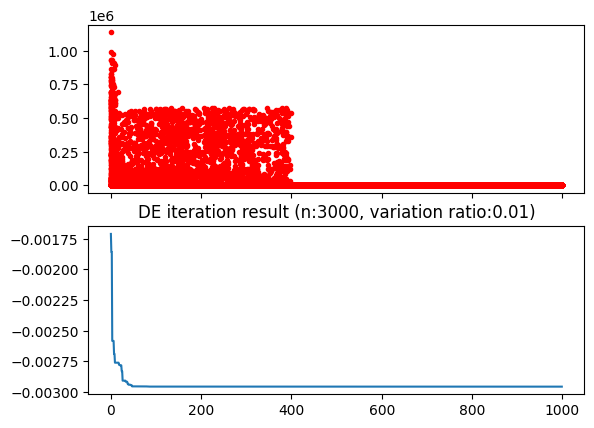

best_x: [0.18749999 1.75      ] 
best_obj_func: [-0.00295639]
total time cost : 3.634394645690918


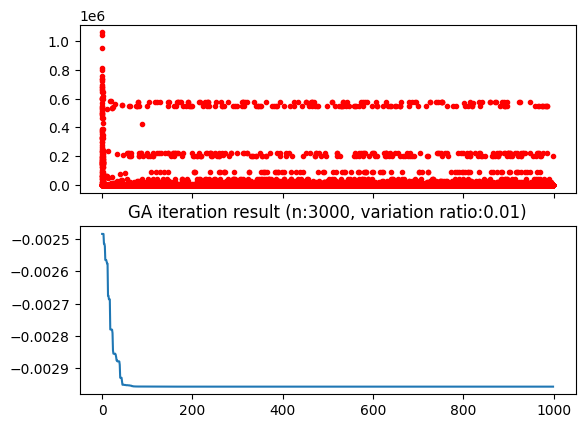

TypeError: PSO.__init__() got an unexpected keyword argument 'n_dim'

In [34]:
optimize_f_hat(obj_func_lm)

best_x: [-0.09696032  0.96187515] 
best_obj_func: [-0.40502435]
total time cost : 115.35064935684204


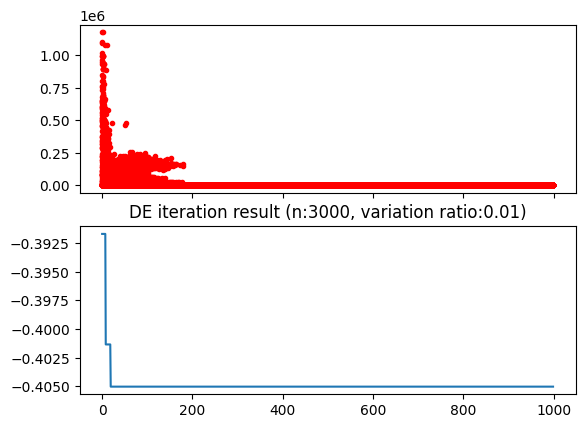

best_x: [-0.06081563  0.96320127] 
best_obj_func: [-0.40502435]
total time cost : 58.76609969139099


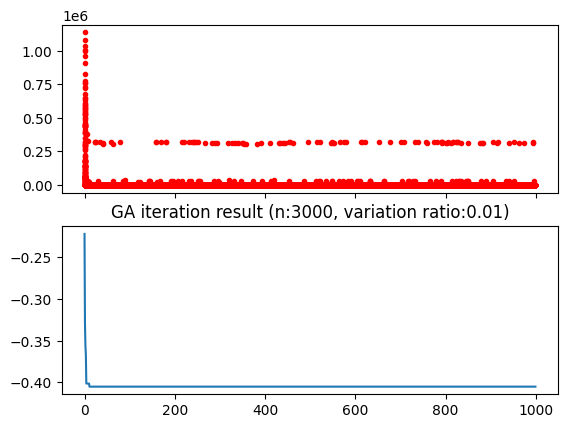

best_x is  [-0.05907794  0.96211127] 
best_y is [-0.40502435]
total time cost : 57.605067014694214


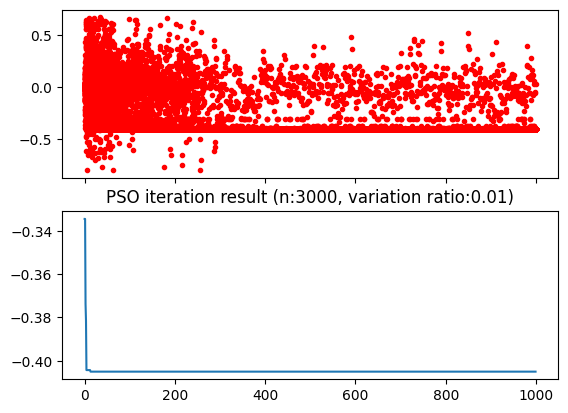

In [ ]:
optimize_f_hat(obj_func_lgb)

best_x: [-0.03050027  0.94425295] 
best_obj_func: [-0.48534438]
total time cost : 57.8217408657074


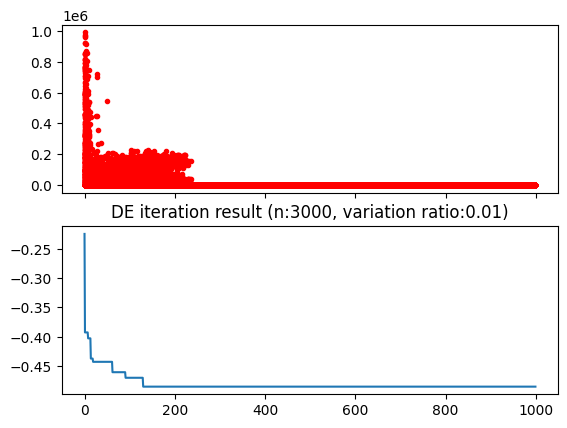

best_x: [-1.0219255   0.53408915] 
best_obj_func: [-0.46070531]
total time cost : 28.54315972328186


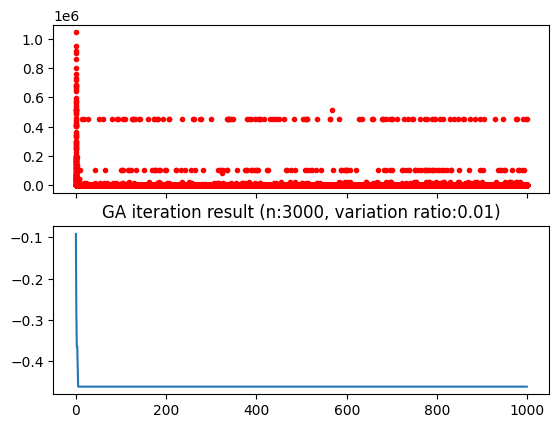

best_x is  [-0.02583475  0.94430045] 
best_y is [-0.48534438]
total time cost : 26.6928288936615


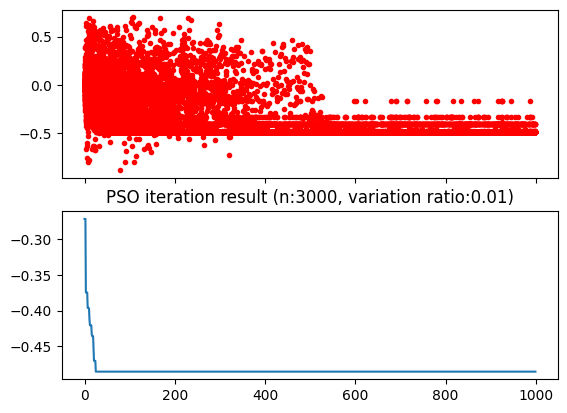

In [ ]:
optimize_f_hat(obj_func_xgb)

best_x: [-0.89191508  0.50000008] 
best_obj_func: [-0.4893102]
total time cost : 90.02135825157166


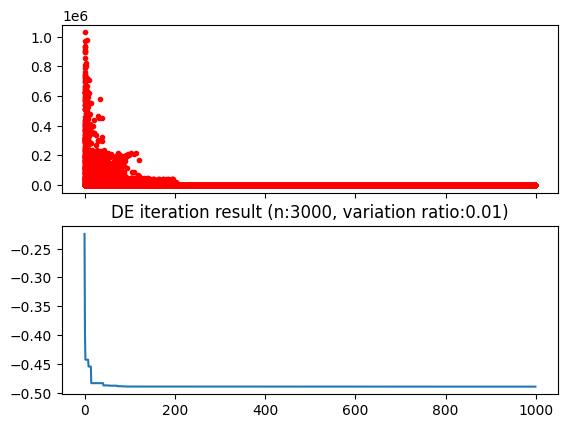

best_x: [-0.89191678  0.50000021] 
best_obj_func: [-0.48931015]
total time cost : 47.22431302070618


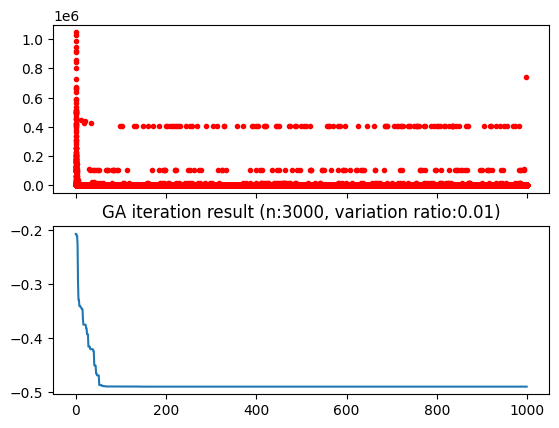

best_x is  [-0.89191509  0.50000006] 
best_y is [-0.4893102]
total time cost : 40.485748052597046


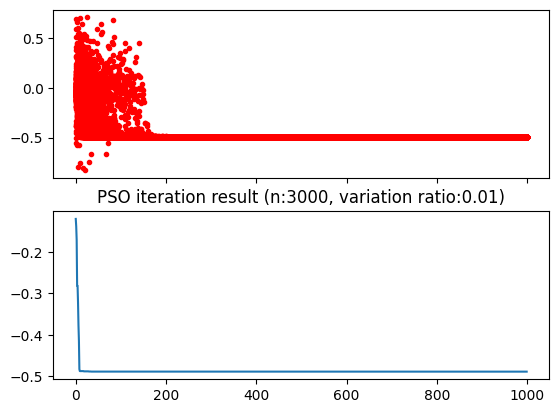

In [ ]:
optimize_f_hat(obj_func_nn)